<a href="https://colab.research.google.com/github/imSebin/UofTSchoolWork/blob/main/STA365HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import pymc as pm

### Q1

1. ~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~

2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html

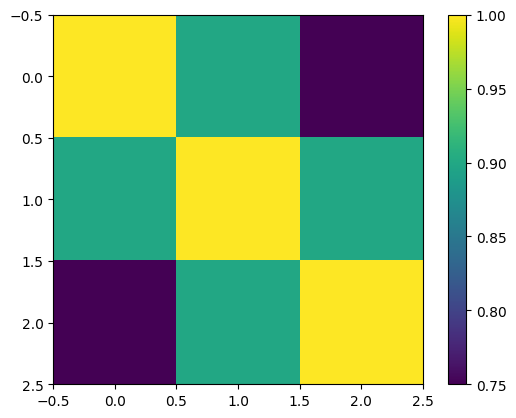

In [2]:
p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();

(array([0.00810983, 0.00810983, 0.05676881, 0.04865898, 0.12164746,
        0.09731796, 0.12975729, 0.07298847, 0.05676881, 0.04054915,
        0.04865898, 0.04054915, 0.03243932, 0.00810983, 0.02432949,
        0.00810983, 0.        , 0.        , 0.        , 0.00810983]),
 array([ 0.99294599,  2.2260174 ,  3.45908881,  4.69216022,  5.92523163,
         7.15830304,  8.39137445,  9.62444586, 10.85751727, 12.09058868,
        13.32366009, 14.55673151, 15.78980292, 17.02287433, 18.25594574,
        19.48901715, 20.72208856, 21.95515997, 23.18823138, 24.42130279,
        25.6543742 ]),
 <BarContainer object of 20 artists>)

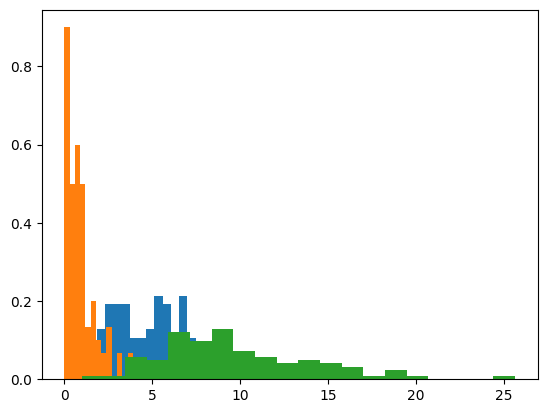

In [3]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))
plt.hist(y[:,0], bins=20, density=True)
plt.hist(y[:,1], bins=20, density=True)
plt.hist(y[:,2], bins=20, density=True)

In [4]:
with pm.Model() as onepass_marg_copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_', pm.Normal.icdf(pm.math.exp(pm.logcdf(pm.Gamma.dist(alpha=p0, beta=1), y0)), mu=0, sigma=1))

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_', pm.Normal.icdf(pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)), mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_', pm.Normal.icdf(pm.math.exp(pm.logcdf(pm.ChiSquared.dist(nu=p2), y2)), mu=0, sigma=1))

    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                                     pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    copula_onepass = pm.sample()

Output()

ERROR:pymc.stats.convergence:There were 437 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


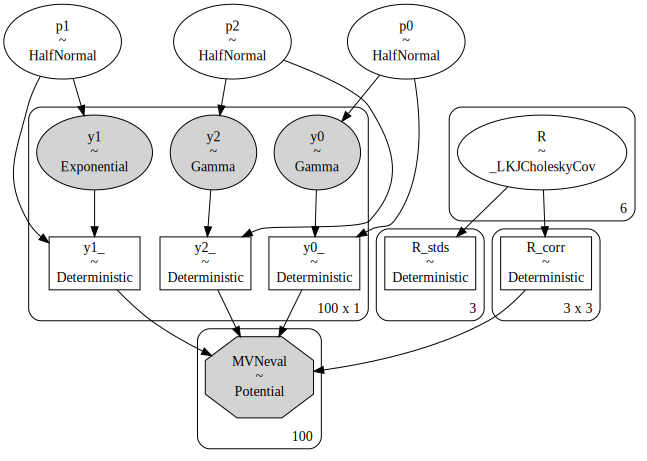

In [10]:
pm.model_to_graphviz(onepass_marg_copula)

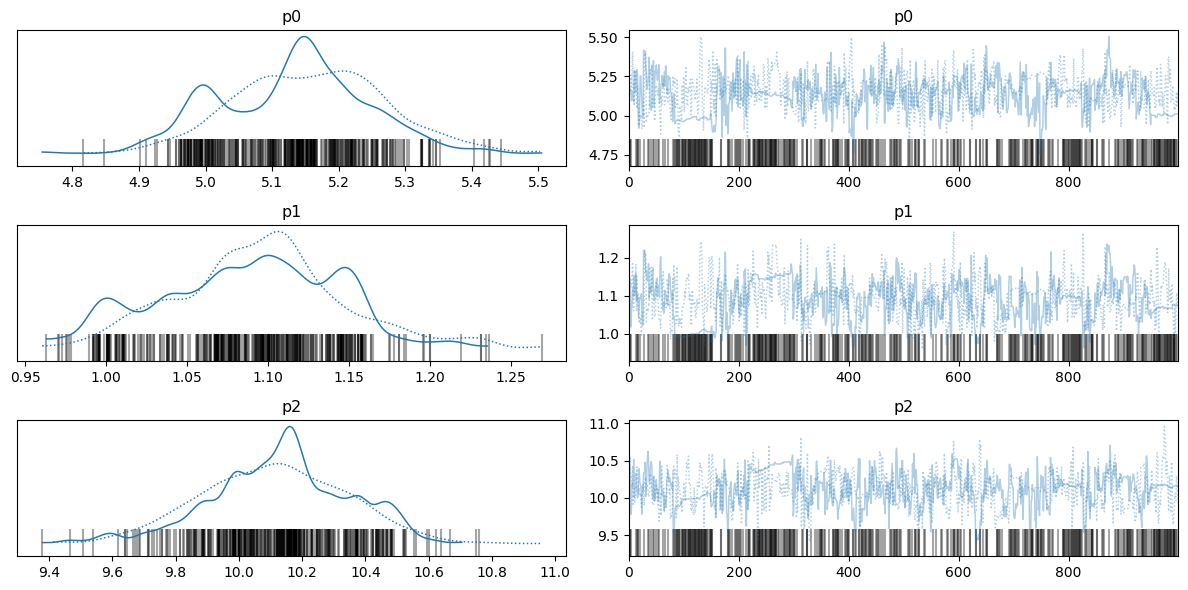

In [17]:
az.plot_trace(copula_onepass, var_names=['p0','p1','p2'])
plt.tight_layout()

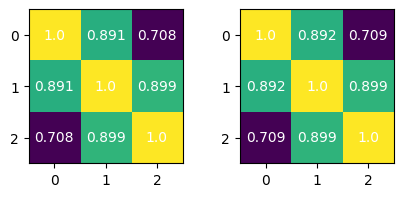

In [32]:
fig,ax = plt.subplots(1,2,figsize=(5,2))
for i,c in enumerate(list(copula_onepass.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

In [20]:
with pm.Model() as twopass_marg:
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:, 0])

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:, 1])

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:, 2])

    marg = pm.sample()

Output()

In [21]:
p0_sample = marg.posterior['p0'].values.flatten()
p1_sample = marg.posterior['p1'].values.flatten()
p2_sample = marg.posterior['p2'].values.flatten()

y0_ = stats.gamma.cdf(y[:, 0], a=p0_sample.mean(), scale=1)
y1_ = stats.expon.cdf(y[:, 1], scale=1/p1_sample.mean())
y2_ = stats.chi2.cdf(y[:, 2], df=p2_sample.mean())
y = np.stack([y0_, y1_, y2_], axis=1)

In [22]:
with pm.Model() as twopass_copula:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                                     stats.norm.ppf(y)))

    copula_twopass = pm.sample()

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

ERROR:pymc.stats.convergence:There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


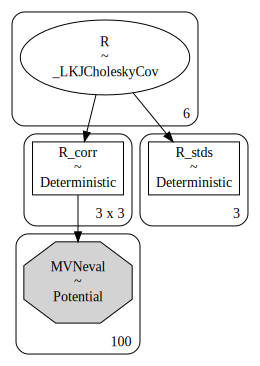

In [25]:
pm.model_to_graphviz(twopass_copula)

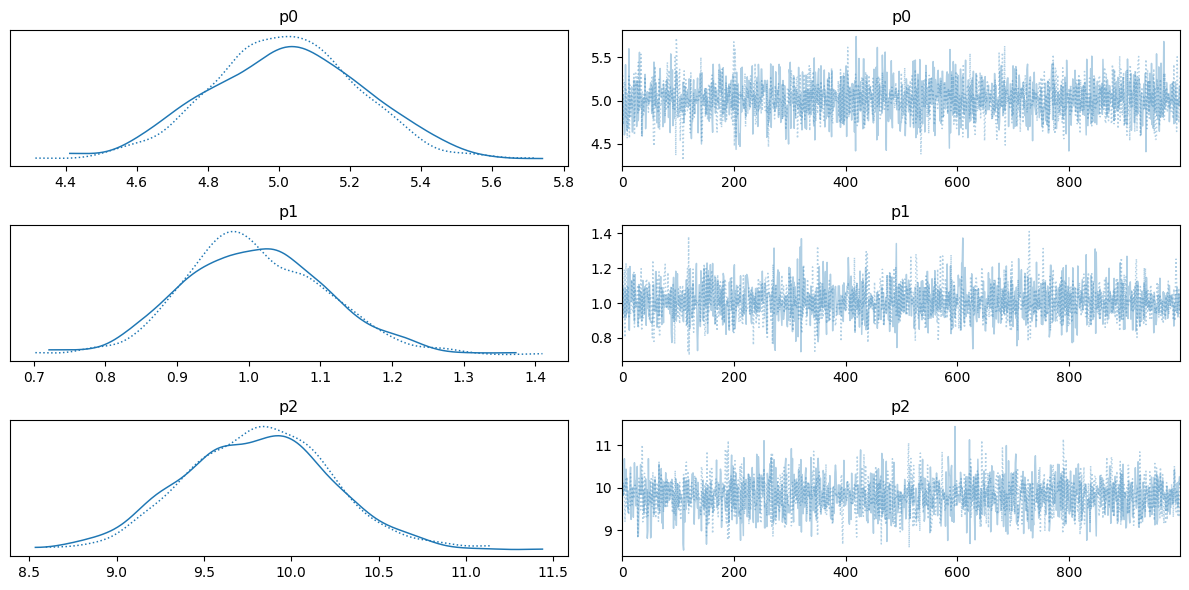

In [27]:
az.plot_trace(marg, var_names=['p0','p1','p2'])
plt.tight_layout()

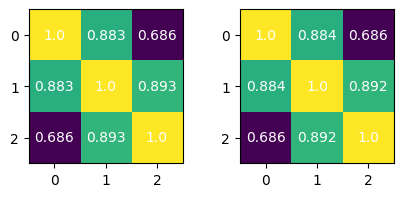

In [30]:
fig,ax = plt.subplots(1,2,figsize=(5,2))
for i,c in enumerate(list(copula_twopass.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

3. Describe what a copula is and how the two versions of code implement it

**What is a Copula?**

- Copulas decompose a joint into their marginals (which have no correlation) and fit a function that couples them together (ergo the name) and thus allows us to specify the correlation seperately. In other words, it helps us understand how different variables are related to each other, regardless of their individual distributions.

**Implementation in the Code:**

- One-pass: This version models the marginal distributions and the copula simultaneously within a *single pass*. It first defines the marginal distributions using the Gamma, Exponential, and Chi-Squared distributions, respectively. After transforming each marginal into standard normals, the correlation structure amongst the three variables is modeled on the correlation matrix $R$ (copula) via a LKJ prior. Basically, this approach directly estimates the dependence structure along with the marginal parameters.

- Two pass: This version models the marginal distributions and the copula separately in *two passes*. First, with the first model, it estimates the parameters of the marginal distributions, and they are FIXED. Then, after transforming, we do the exact same thing as the latter step of the one-pass method. The difference being that the marginals are estimated first, and the copula model is fit afterward.

4. Describe how to use this to create arbitrary multivariate GLM regressions

- For example, if we wanted to model the relationship between two count variables (e.g. number of website visits and number of sales) and some independent variables (e.g. marketing spend, season). We could use Poisson regression for the marginal distributions and fit a copula to model the dependence between the two count variables. Then we can estimate the impact of the independent variables on both dependent variables while accounting for their correlation.

### 2.

Perform multivariate regression with spike and slab variable selection priors and compare inference to analogous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

In [33]:
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "martinellis/nhl-game-data",
  "game_teams_stats.csv",
)

df.head()

<ipython-input-33-60d123585eac>:1: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 775k/775k [00:00<00:00, 92.6MB/s]

Extracting zip of game_teams_stats.csv...


,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


In [50]:
cols = ["won", "goals", "shots", "hits", "pim", "powerPlayOpportunities", "giveaways", "takeaways", "faceOffWinPercentage"]
df1 = df.dropna()[cols]

m = ["won", "goals", "shots"]
y = df1[m].values

# Standardizing values to reduce extreme curvature
scaler = StandardScaler()
y = scaler.fit_transform(df1[m].values)
X = scaler.fit_transform(df1.drop(columns=m).values)
n, p = X.shape
m = y.shape[1]

In [60]:
with pm.Model() as spike_and_slab:
    p_ = pm.Beta('p_', alpha=1, beta=1, shape=p)
    spike = pm.Bernoulli('spike', p=p_, shape=p)
    slab = pm.Normal('slab', mu=0, sigma=10, shape=(p, m))

    betas = pm.Deterministic('betas', spike[:, None] * slab)
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)

    y_obs = pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)

    idata_spike_slab = pm.sample()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


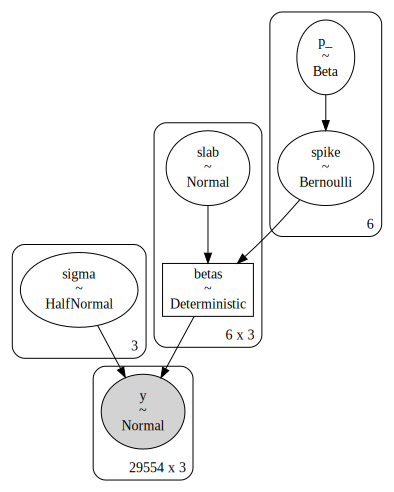

In [61]:
pm.model_to_graphviz(spike_and_slab)

In [63]:
with pm.Model() as diffuse_normal:
    betas = pm.Normal('betas', mu=0, sigma=10, shape=(p, m))
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)

    y_obs = pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)

    idata_diffuse = pm.sample()

Output()

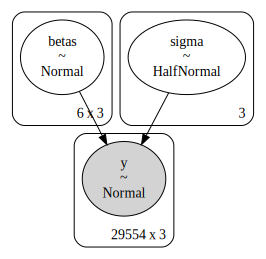

In [64]:
pm.model_to_graphviz(diffuse_normal)

In [102]:
az.summary(idata_diffuse, var_names=["betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.063,0.006,-0.073,-0.052,0.0,0.0,4542.0,1722.0,1.0
"betas[0, 1]",-0.093,0.006,-0.103,-0.082,0.0,0.0,4946.0,1593.0,1.0
"betas[0, 2]",0.017,0.006,0.006,0.028,0.0,0.0,5571.0,1598.0,1.0
"betas[1, 0]",-0.032,0.006,-0.042,-0.021,0.0,0.0,4339.0,1444.0,1.0
"betas[1, 1]",0.030,0.006,0.018,0.040,0.0,0.0,2940.0,1487.0,1.0
"betas[1, 2]",-0.089,0.006,-0.101,-0.079,0.0,0.0,4777.0,1419.0,1.0
"betas[2, 0]",0.017,0.006,0.006,0.027,0.0,0.0,4321.0,1604.0,1.0
"betas[2, 1]",0.078,0.006,0.067,0.089,0.0,0.0,4856.0,1590.0,1.0
"betas[2, 2]",0.188,0.006,0.177,0.199,0.0,0.0,4724.0,1558.0,1.0
"betas[3, 0]",-0.033,0.006,-0.044,-0.022,0.0,0.0,3813.0,1478.0,1.0


In [66]:
az.summary(idata_spike_slab, var_names=["betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.031,0.032,-0.069,-0.000,0.022,0.000,3.0,56.0,2.23
"betas[0, 1]",-0.046,0.047,-0.100,-0.000,0.033,0.000,3.0,54.0,2.23
"betas[0, 2]",0.008,0.009,-0.000,0.023,0.006,0.001,3.0,2.0,2.23
"betas[1, 0]",-0.034,0.007,-0.047,-0.022,0.002,0.000,11.0,357.0,1.12
"betas[1, 1]",0.026,0.007,0.012,0.038,0.003,0.000,5.0,83.0,1.29
"betas[1, 2]",-0.088,0.006,-0.099,-0.077,0.000,0.000,2948.0,1650.0,1.01
"betas[2, 0]",0.020,0.006,0.008,0.031,0.002,0.000,9.0,313.0,1.14
"betas[2, 1]",0.082,0.007,0.068,0.095,0.003,0.000,6.0,61.0,1.26
"betas[2, 2]",0.187,0.006,0.176,0.198,0.000,0.000,1300.0,1499.0,1.01
"betas[3, 0]",-0.038,0.008,-0.052,-0.024,0.004,0.000,5.0,114.0,1.34


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

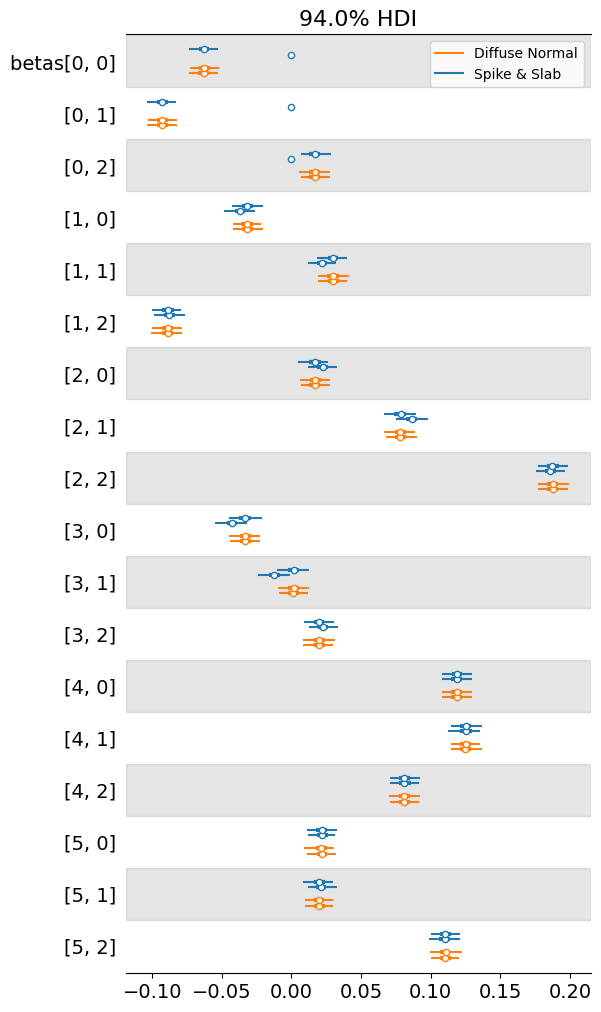

In [68]:
az.plot_forest([idata_spike_slab, idata_diffuse], model_names=["Spike & Slab", "Diffuse Normal"], var_names=["betas"])

/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

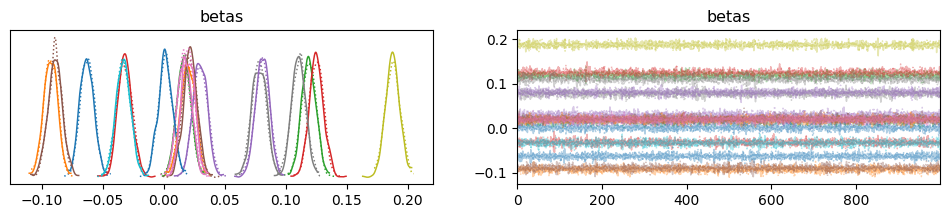

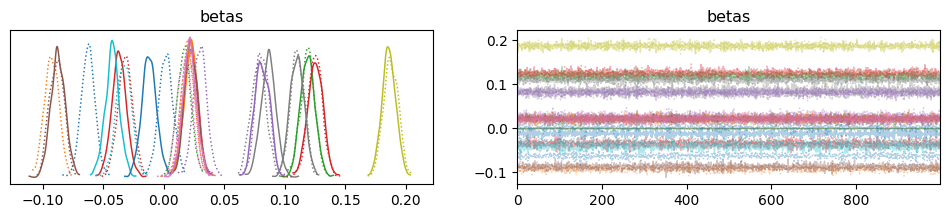

In [101]:
az.plot_trace(idata_diffuse, var_names=["betas"])
az.plot_trace(idata_spike_slab, var_names=["betas"])

<Axes: >

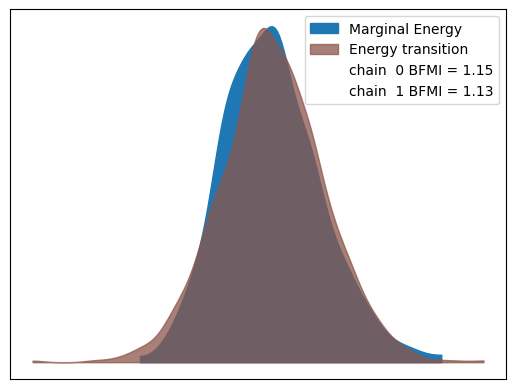

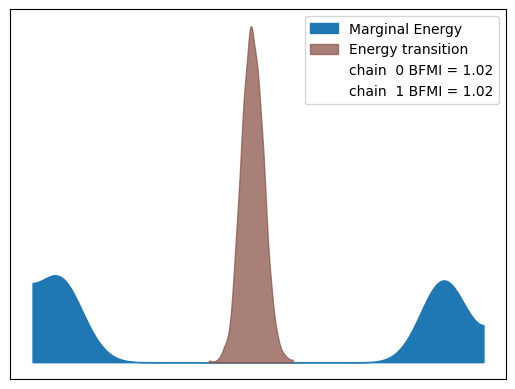

In [100]:
az.plot_energy(idata_diffuse)
az.plot_energy(idata_spike_slab)

### 3.

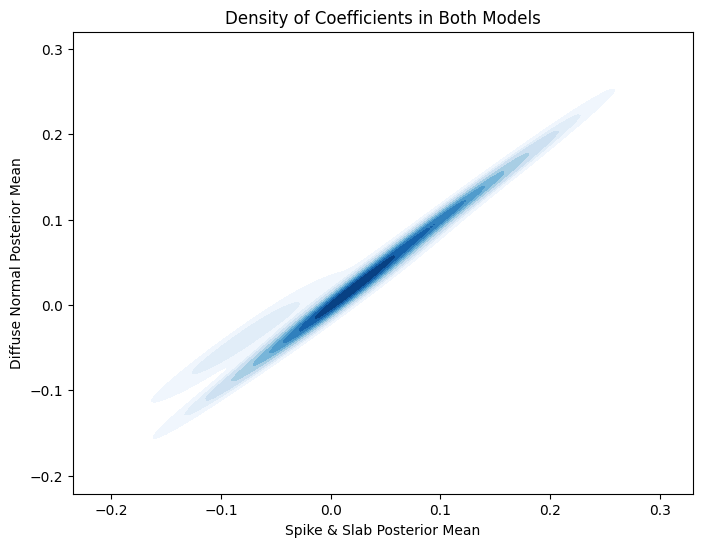

In [99]:
betas_diffuse = idata_diffuse.posterior["betas"].mean(dim=["chain", "draw"]).values.flatten()
betas_spike_slab = idata_spike_slab.posterior["betas"].mean(dim=["chain", "draw"]).values.flatten()

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(x=betas_diffuse, y=betas_spike_slab, fill=True, cmap="Blues")
ax.set_xlabel("Spike & Slab Posterior Mean")
ax.set_ylabel("Diffuse Normal Posterior Mean")
ax.set_title("Density of Coefficients in Both Models")
plt.show()

Perform multivariate regression with the horseshoe variable selection prior and compare inference to analogous inference with spike and slab priors.

In [88]:
with pm.Model() as horseshoe:
    tau = pm.HalfCauchy('tau', beta=1)
    lam = pm.HalfCauchy('lam', beta=1, shape=p)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=(p, m))

    betas = pm.Deterministic('betas', tau * lam[:, None] * beta)
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)

    y_obs = pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)

    idata_horseshoe = pm.sample()

Output()

ERROR:pymc.stats.convergence:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


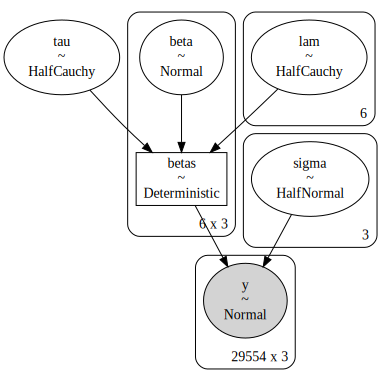

In [89]:
pm.model_to_graphviz(horseshoe)

In [90]:
az.summary(idata_spike_slab, var_names=["betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.031,0.032,-0.069,-0.000,0.022,0.000,3.0,56.0,2.23
"betas[0, 1]",-0.046,0.047,-0.100,-0.000,0.033,0.000,3.0,54.0,2.23
"betas[0, 2]",0.008,0.009,-0.000,0.023,0.006,0.001,3.0,2.0,2.23
"betas[1, 0]",-0.034,0.007,-0.047,-0.022,0.002,0.000,11.0,357.0,1.12
"betas[1, 1]",0.026,0.007,0.012,0.038,0.003,0.000,5.0,83.0,1.29
"betas[1, 2]",-0.088,0.006,-0.099,-0.077,0.000,0.000,2948.0,1650.0,1.01
"betas[2, 0]",0.020,0.006,0.008,0.031,0.002,0.000,9.0,313.0,1.14
"betas[2, 1]",0.082,0.007,0.068,0.095,0.003,0.000,6.0,61.0,1.26
"betas[2, 2]",0.187,0.006,0.176,0.198,0.000,0.000,1300.0,1499.0,1.01
"betas[3, 0]",-0.038,0.008,-0.052,-0.024,0.004,0.000,5.0,114.0,1.34


In [91]:
az.summary(idata_horseshoe, var_names=["betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.063,0.006,-0.073,-0.052,0.0,0.0,1987.0,1593.0,1.0
"betas[0, 1]",-0.092,0.006,-0.103,-0.082,0.0,0.0,1925.0,1939.0,1.0
"betas[0, 2]",0.017,0.006,0.006,0.027,0.0,0.0,2091.0,1360.0,1.0
"betas[1, 0]",-0.031,0.006,-0.043,-0.021,0.0,0.0,2167.0,1630.0,1.0
"betas[1, 1]",0.029,0.006,0.018,0.041,0.0,0.0,2004.0,1363.0,1.0
"betas[1, 2]",-0.088,0.006,-0.099,-0.078,0.0,0.0,1959.0,1516.0,1.0
"betas[2, 0]",0.017,0.006,0.006,0.028,0.0,0.0,2616.0,1597.0,1.0
"betas[2, 1]",0.078,0.006,0.067,0.089,0.0,0.0,1936.0,1544.0,1.0
"betas[2, 2]",0.187,0.006,0.177,0.198,0.0,0.0,1942.0,1695.0,1.0
"betas[3, 0]",-0.031,0.006,-0.043,-0.020,0.0,0.0,1909.0,1562.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

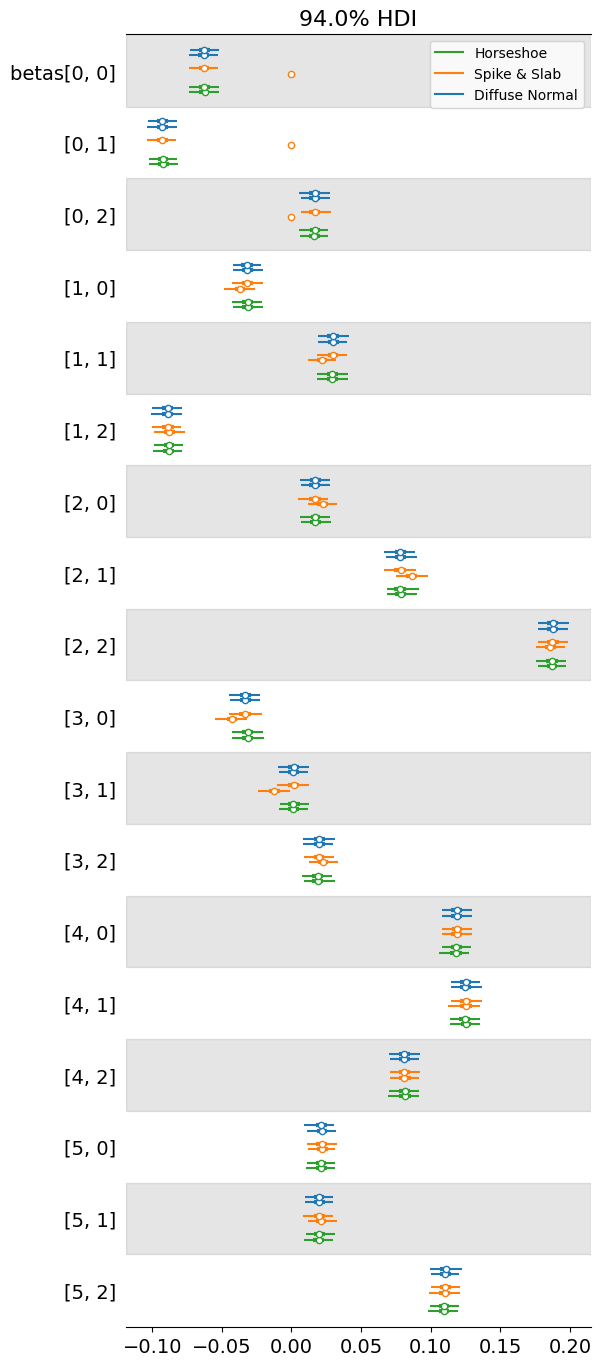

In [92]:
az.plot_forest([idata_diffuse, idata_spike_slab, idata_horseshoe], model_names=["Diffuse Normal", "Spike & Slab", "Horseshoe"], var_names=["betas"])

/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

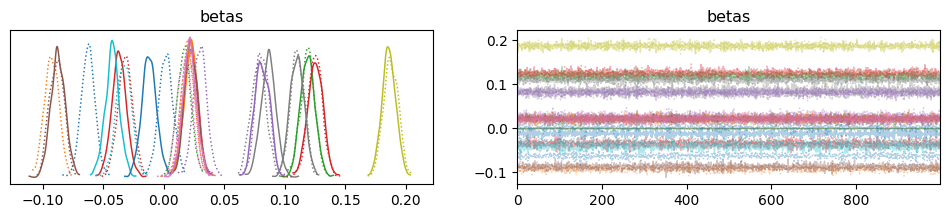

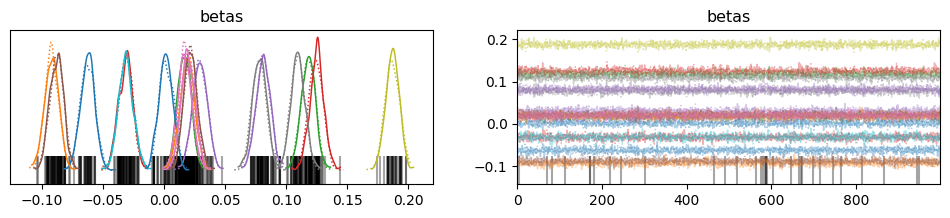

In [93]:
az.plot_trace(idata_spike_slab, var_names=["betas"])
az.plot_trace(idata_horseshoe, var_names=["betas"])

<Axes: >

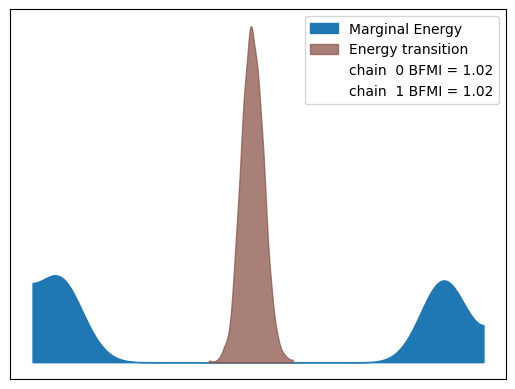

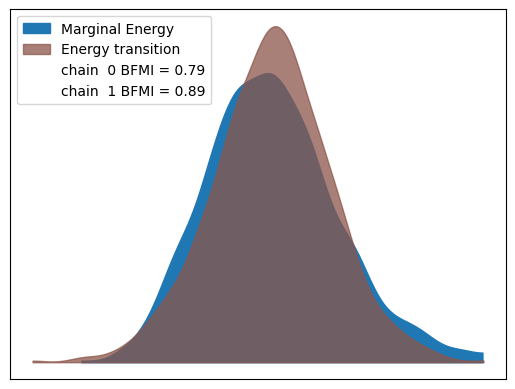

In [94]:
az.plot_energy(idata_spike_slab)
az.plot_energy(idata_horseshoe)

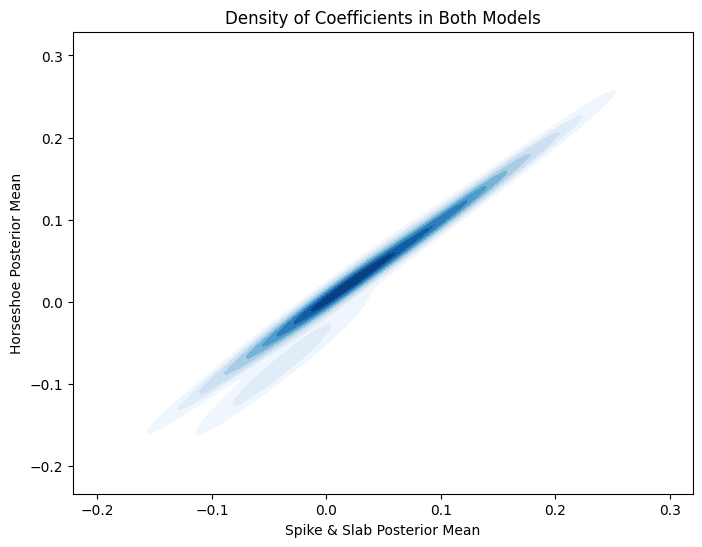

In [97]:
betas_spike_slab = idata_spike_slab.posterior["betas"].mean(dim=["chain", "draw"]).values.flatten()
betas_horseshoe = idata_horseshoe.posterior["betas"].mean(dim=["chain", "draw"]).values.flatten()

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(x=betas_spike_slab, y=betas_horseshoe, fill=True, cmap="Blues")
ax.set_xlabel("Spike & Slab Posterior Mean")
ax.set_ylabel("Horseshoe Posterior Mean")
ax.set_title("Density of Coefficients in Both Models")
plt.show()